In [13]:
import pandas as pd
from castle.common import GraphDAG
from castle.metrics import MetricsDAG
from castle.datasets import DAG, IIDSimulation
from castle.algorithms import PC
from castle.common.priori_knowledge import PrioriKnowledge

import networkx as nx
from dowhy import gcm
import numpy as np
import matplotlib.pyplot as plt

In [14]:
#Causal graph
causal_graph = nx.DiGraph([('d', 'messageReceived'),
                           ('d', 'graft'),
                           ('d', 'prune'),
                           ('d', 'iwant'),
                           ('dlo', 'graft'),
                           ('dhi', 'prune'),
                           ('dscore', 'graft'),
                           ('dscore', 'prune'),
                           ('dlazy', 'iwant'),
                           ('dlazy', 'ihave'),
                           ('dout', 'graft'),
                           ('dout', 'prune'),
                           ('gossipFactor', 'iwant'),
                           ('gossipFactor', 'ihave'),
                           ('interval', 'graft'),
                           ('interval', 'prune'),
                           ('interval', 'iwant'),
                           ('interval', 'ihave'),
                           ('topology', 'graft'),
                           ('topology', 'prune'),
                           ('topology', 'propagationTime'),
                           ('topology', 'messageReceived'),
                           ('prune', 'graft'),
                           ('prune', 'propagationTime'),
                           ('messageReceived', 'messageOverhead'),
                           ('messageOverhead', 'bandwidth'),
                           ('iwant', 'bandwidth'),
                           ('ihave', 'bandwidth'),
                           ('messageReceived', 'bandwidth')
                         ])

In [15]:
#From digraph to adjancency matrix

# true_causal_matrix = nx.adjacency_matrix(causal_graph)
true_causal_matrix = nx.to_numpy_array(causal_graph)

print(true_causal_matrix)
print(causal_graph.nodes)

[[0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
['d', 'messageReceived', 'graft', 'prune', 'iwant', 'dlo', 'dhi', 'dscore', 'dlaz

In [16]:
#Treat dataset

#Import data 
# data = pd.read_csv('../datasets/consolidated.csv',header=0, index_col=0)
data = pd.read_csv('../datasets/experiments.csv',header=0, index_col=0)
consolidated = pd.DataFrame(data)

consolidated = consolidated.drop(columns=['identifier', 'n_nodes', 'consensus', 'messageDuplicated'])
consolidated = consolidated.rename(columns={'topology':'top'})
consolidated['topology'] = 0
consolidated.loc[consolidated['top'] == 'general', 'topology'] = 1
consolidated = consolidated.drop(columns=['top'])
# consolidated.head(100)

X = consolidated.to_numpy()
print(X)

KeyError: "['messageDuplicated'] not found in axis"

In [ ]:
# structure learning
priori = PrioriKnowledge(X.shape[1])
priori.add_forbidden_edges([(2,0),(0,6),(6,0),(3,6),(9,6),(9,10),(16,10),(16,12),(8,13),(13,8),(9,11),(7,11),(11,7),(10,7),(7,10)])
# (2,0) = graft -> d, (0,6) = d -> dhi, (6,0) = dhi -> d, (3,6) = prune -> dhi, (9,6) = ihave -> dhi, (9,10) = ihave -> dout
# (16,10) = bandwidth -> dout, (16,12) = bandwidth -> interval, (8,13) = dlazy -> topology, (13,8) = topology -> dlazy
# (9,11) = ihave -> gossipFactor, (7,11) = dScore -> gossipFactor, (11,7) = GossipFactor -> dScore, (10,7) = dout -> dScore, (7,10) = dScore -> dout
pc = PC(variant='original', priori_knowledge=priori)
pc.learn(X)

# plot predict_dag and true_dag
GraphDAG(pc.causal_matrix, true_causal_matrix, 'result')

# calculate metrics
mt = MetricsDAG(pc.causal_matrix, true_causal_matrix)
print(mt.metrics)

In [ ]:
learned_causal_graph = nx.from_numpy_array(pc.causal_matrix, create_using=nx.DiGraph)

mapping = {0:'d', 1:'messageReceived', 2:'graft', 3:'prune', 4:'iwant', 5:'dlo', 6:'dhi', 7:'dscore', 8:'dlazy', 9:'ihave', 10:'dout', 11:'gossipFactor', 12:'interval', 13:'topology', 14:'propagationTime', 15:'messageOverhead', 16:'bandwidth'}
# nx.set_node_attributes(learned_causal_graph, labels, "name")
H = nx.relabel_nodes(learned_causal_graph, mapping)

fig, ax = plt.subplots(figsize=(15,20)) 
gcm.util.plot(H)#, figure_size=[15, 10])

In [ ]:
pc_cat = PC(ci_test="chi2")

pc_cat.learn(X)

# plot predict_dag and true_dag
GraphDAG(pc_cat.causal_matrix, true_causal_matrix, 'result')

# calculate metrics
mt = MetricsDAG(pc_cat.causal_matrix, true_causal_matrix)
print(mt.metrics)

In [ ]:
learned_causal_graph =  nx.from_numpy_array(pc_cat.causal_matrix)

mapping = {0:'d', 1:'messageReceived', 2:'graft', 3:'prune', 4:'iwant', 5:'dlo', 6:'dhi', 7:'dscore', 8:'dlazy', 9:'ihave', 10:'dout', 11:'gossipFactor', 12:'interval', 13:'topology', 14:'propagationTime', 15:'messageOverhead', 16:'bandwidth'}
# nx.set_node_attributes(learned_causal_graph, labels, "name")
H = nx.relabel_nodes(learned_causal_graph, mapping)

fig, ax = plt.subplots(figsize=(15,20)) 
gcm.util.plot(H)#, figure_size=[15, 10])

In [ ]:
pc_g2 = PC(ci_test="g2")

pc_g2.learn(X)

# plot predict_dag and true_dag
GraphDAG(pc_g2.causal_matrix, true_causal_matrix, 'result')

# calculate metrics
mt = MetricsDAG(pc_g2.causal_matrix, true_causal_matrix)
print(mt.metrics)

In [ ]:
learned_causal_graph =  nx.from_numpy_array(pc_g2.causal_matrix)

mapping = {0:'d', 1:'messageReceived', 2:'graft', 3:'prune', 4:'iwant', 5:'dlo', 6:'dhi', 7:'dscore', 8:'dlazy', 9:'ihave', 10:'dout', 11:'gossipFactor', 12:'interval', 13:'topology', 14:'propagationTime', 15:'messageOverhead', 16:'bandwidth'}
# nx.set_node_attributes(learned_causal_graph, labels, "name")
H = nx.relabel_nodes(learned_causal_graph, mapping)

fig, ax = plt.subplots(figsize=(15,20)) 
gcm.util.plot(H)#, figure_size=[15, 10])

In [ ]:
from castle.common.independence_tests import CITest

pc_cat_alt = PC(ci_test=CITest.cressie_read)
pc_cat_alt.learn(X)

# plot predict_dag and true_dag
GraphDAG(pc_cat_alt.causal_matrix, true_causal_matrix, 'result')

# calculate metrics
mt = MetricsDAG(pc_cat_alt.causal_matrix, true_causal_matrix)
print(mt.metrics)

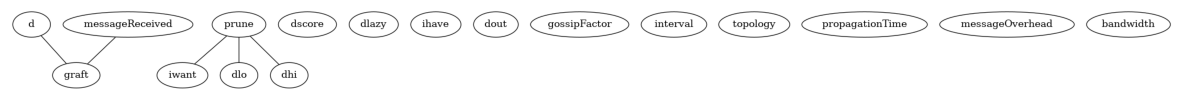

In [17]:
learned_causal_graph =  nx.from_numpy_array(pc_cat_alt.causal_matrix)

mapping = {0:'d', 1:'messageReceived', 2:'graft', 3:'prune', 4:'iwant', 5:'dlo', 6:'dhi', 7:'dscore', 8:'dlazy', 9:'ihave', 10:'dout', 11:'gossipFactor', 12:'interval', 13:'topology', 14:'propagationTime', 15:'messageOverhead', 16:'bandwidth'}
# nx.set_node_attributes(learned_causal_graph, labels, "name")
H = nx.relabel_nodes(learned_causal_graph, mapping)

fig, ax = plt.subplots(figsize=(15,20)) 
gcm.util.plot(H)#, figure_size=[15, 10])